In [1]:
from tqdm import tqdm
from time import time
from tqdm import trange

import matplotlib.pyplot as plt
import numpy as np
import scipy

import jax
import jax.flatten_util as flatten_util
import jax.numpy as jnp

from flax import linen as nn

from typing import NamedTuple

In [2]:
seed = 42

In [3]:
class SpringState(NamedTuple):
    phi: jnp.ndarray
    buffer: jnp.ndarray
    buffer_index: jnp.ndarray
    r_hat: float
    beta: float
    checkpoint_idx: int

In [4]:
class SpringCleanState(NamedTuple):
    phi: jnp.ndarray

In [5]:
class ResNet(nn.Module):
    """A simple ResNet model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=50)(jnp.sin(2 * jnp.pi * x))
        x = nn.tanh(x)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        x = nn.Dense(features=1)(x)
        return x


model_fn = ResNet()

In [6]:
def scalar_model_fn(params, batch):
    return model_fn.apply(params, batch)[0]


model_grad = jax.value_and_grad(scalar_model_fn, argnums=0)


def raveled_grad_fn(params, batch):
    value, grad = model_grad(params, batch)
    return value, flatten_util.ravel_pytree(grad)[0]


jacobian_fn = jax.jit(jax.vmap(raveled_grad_fn, in_axes=(None, 0), out_axes=(0, 0)))

In [7]:
key = jax.random.PRNGKey(seed)
ord = 15 #Change to make more ill conditioned

coeff = jax.random.normal(key, shape=(ord,))
poly = np.polynomial.chebyshev.Chebyshev(coeff)

def target_fn(x):
    return poly(jnp.sin(2 * jnp.pi * x)) / np.sqrt(ord)

Text(0, 0.5, 'f(s)')

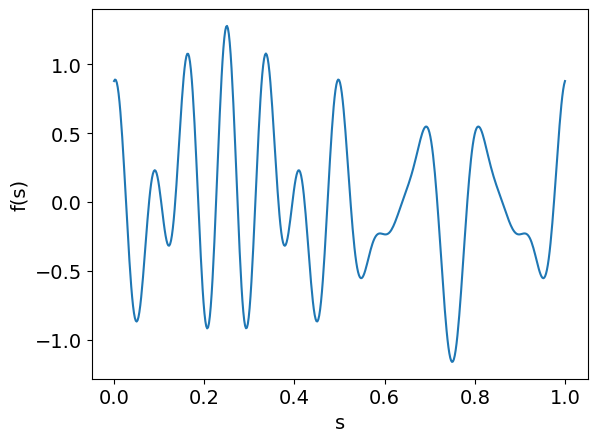

In [8]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

xs = np.linspace(0,1,500)
plt.plot(xs, target_fn(xs))
plt.xlabel("s")
plt.ylabel("f(s)")
#plt.savefig("NN_target_fn.pdf", bbox_inches='tight')

In [9]:
def loss_fn(model_params, xs):
    """Mean-squared error loss"""
    predictions = model_fn.apply(model_params, xs)
    targets = target_fn(xs)

    return jnp.mean((predictions - targets) ** 2)


loss_fn = jax.jit(loss_fn)
loss_fn_grad = jax.jit(jax.value_and_grad(loss_fn, argnums=0))

In [10]:
rng = jax.random.PRNGKey(seed)

rng, key = jax.random.split(rng)
dummy_x = jax.random.uniform(key, shape=(100, 1))

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
param_vec, unravel_fn = flatten_util.ravel_pytree(params)

initial_params = params

print(f"nparams: {jax.flatten_util.ravel_pytree(params)[0].shape[0]}")

nparams: 7801


## Kaczmarz Algorithm (Without adaptive acceleration)

In [75]:
def get_NGD_optimizer(params, rng, dummy_x, alpha, lamb):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    opt_state = []

    def step(params, batch, targets, opt_state, rng):
        batch_size = batch.shape[0]

        predictions, jacobian = jacobian_fn(params, batch)
        residuals = (targets - predictions)

        loss = jnp.sum(residuals**2) / batch_size

        jacobian /= jnp.sqrt(batch_size)
        residuals /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)

        ravel_update = jacobian.T @ jax.scipy.linalg.solve(T, residuals, assume_a="pos")

        update = unravel_fn(ravel_update)
        params = jax.tree.map(lambda p, u: p + alpha * u, params, update)

        return params, [], rng, loss, None

    return opt_state, jax.jit(step), rng

In [12]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
alpha = 0.5 #learning rate, 
num_it = 500

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_NGD_optimizer(params, rng, dummy_x, alpha, lamb)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

Loss 1.317e-06: 100%|████████████████████████| 500/500 [00:10<00:00, 48.84its/s]


Text(0, 0.5, 'Loss estimate')

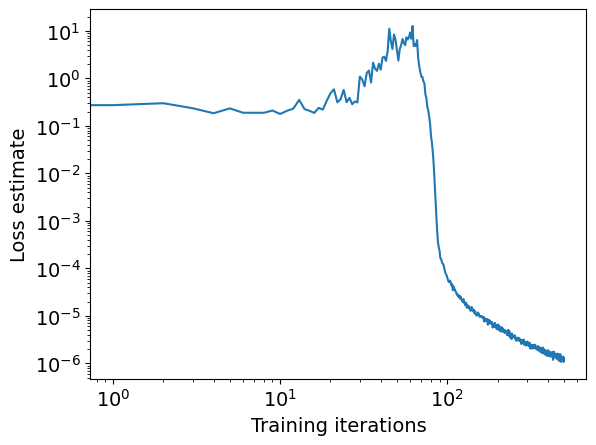

In [13]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## Kaczmarz++ Algorithm

In [76]:
def get_kaczmarzpp_optimizer(params, rng, dummy_x, alpha, eta, lamb, p, accelerated=True):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    opt_state = []
    mtm = jnp.zeros_like(param_vec)

    # Momentum update parameters
    rho = 0.0
    mtm_param = 0.0 if not accelerated else (1 - rho) / (1 + rho)
    r_hat = 1.0
    checkpoint_idx = 1

    residuals = []

    def step(params, batch, targets, opt_state, rng, step_idx):
        nonlocal mtm, rho, r_hat, checkpoint_idx, mtm_param, alpha, residuals

        batch_size = batch.shape[0]

        predictions, jacobian = jacobian_fn(params, batch)
        residual = (targets - predictions)

        # Save normalized residual for adaptive momentum
        res_norm = jnp.linalg.norm(residual) / jnp.linalg.norm(targets)
        residuals.append(res_norm)

        loss = jnp.sum(residual**2) / batch_size
        
        jacobian /= jnp.sqrt(batch_size)
        residual /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)
        ravel_update = jacobian.T @ jax.scipy.linalg.solve(T, residual, assume_a="pos") # Equivalent to finding w

        # Apply momentum and update
        if not accelerated:
            ravel_step = ravel_update
        else:
            mtm = mtm_param * (mtm - ravel_update)
            ravel_step = ravel_update + eta * mtm

        update = unravel_fn(ravel_step)
        params = jax.tree.map(lambda p, u: p + alpha * u, params, update)

        # Every p steps, update rho and mtm_param adaptively
        if accelerated and step_idx % p == 0 and step_idx >= 2 * p:
            eps_t = jnp.sum(jnp.array(residuals[step_idx - p:step_idx]) ** 2)
            eps_tp = jnp.sum(jnp.array(residuals[step_idx - 2*p:step_idx - p]) ** 2)
            r_ip = eps_t / eps_tp

            a_new = (checkpoint_idx + 1) ** jnp.log(checkpoint_idx + 1)
            a_old = checkpoint_idx ** jnp.log(checkpoint_idx)
            alph = a_old / a_new

            r_hat = alph * r_hat + (1 - alph) * jnp.minimum(1.0, r_ip)
            rho = jnp.maximum(0.0, 1 - r_hat ** (1 / p))
            mtm_param = (1 - rho) / (1 + rho)
            checkpoint_idx += 1

        return params, [], rng, loss, None

    return opt_state, jax.jit(step), rng

In [15]:
rng = jax.random.PRNGKey(seed)

alpha = 0.5 # Learning rate
eta = 0.5 # Momentum strength
lamb = 1e-2 # Regularization parameter
p = 10 # Lookback window for adaptive momentum
accelerated = False

num_it = 500

# Initialize model parameters and data
rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

# Initialize Kaczmarz++ optimizer
opt_state, opt_step, rng = get_kaczmarzpp_optimizer(params, rng, dummy_x, alpha, eta, lamb, p, accelerated)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

Loss 1.317e-06: 100%|████████████████████████| 500/500 [00:09<00:00, 54.19its/s]


Text(0, 0.5, 'Loss estimate')

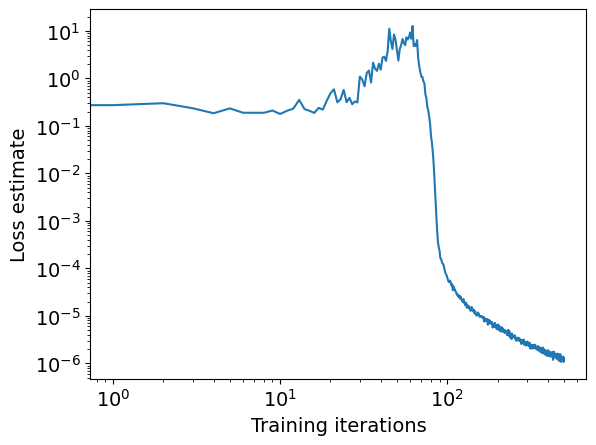

In [16]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## SPRING (clean)

In [11]:
def get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb):    
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    phi = jnp.zeros_like(param_vec)
    opt_state = SpringCleanState(phi)
    
    def step(params, batch, targets, opt_state, rng):
        phi = opt_state.phi
    
        batch_size = batch.shape[0]
        predictions, jacobian = jacobian_fn(params, batch)
        residual = targets - predictions

        loss = jnp.sum(residual ** 2) / batch_size

        correction = residual - jacobian @ (beta * phi)

        jacobian /= jnp.sqrt(batch_size)
        correction /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)
        delta_phi = jacobian.T @ jax.scipy.linalg.solve(T, correction, assume_a="pos")
        
        phi = beta * phi + delta_phi

        update = unravel_fn(phi)        
        params = jax.tree.map(lambda p, u: p + eta * u, params, update)

        opt_state = SpringCleanState(phi)
        
        return params, opt_state, rng, loss, None

    return opt_state, jax.jit(step), rng

In [18]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
eta = 0.5 #learning rate 
beta = 0

num_it = 500

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

loss_list_clean = loss_list

Loss 9.545e-07: 100%|████████████████████████| 500/500 [00:09<00:00, 51.79its/s]


Text(0, 0.5, 'Loss estimate')

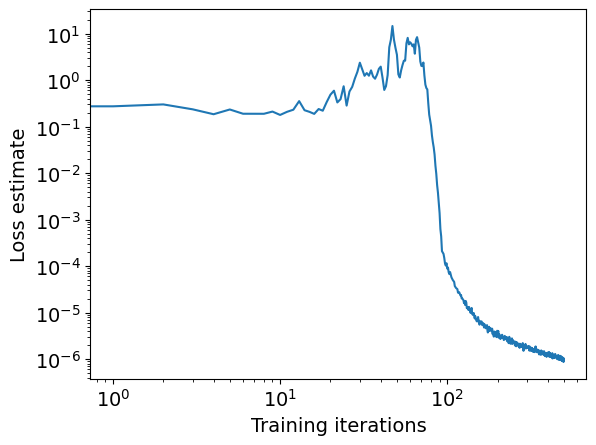

In [19]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## SPRING (Adaptive momentum)

In [12]:
def get_spring_optimizer(params, rng, dummy_x, eta, lamb, p):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    phi = jnp.zeros_like(param_vec)
    buffer = jnp.zeros(2 * p)
    buffer_index = jnp.array(0)
    r_hat = 1.0
    beta = 0.9 #!!!!!
    checkpoint_idx = 1
    
    opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
    
    def step(params, batch, targets, opt_state, rng, step_idx):
        phi, buffer, buffer_index, r_hat, beta, checkpoint_idx = opt_state

        batch_size = batch.shape[0]
        
        predictions, jacobian = jacobian_fn(params, batch)
        residual = targets - predictions

        # Save normalized residual for adaptive momentum
        res_norm = jnp.linalg.norm(residual) / jnp.linalg.norm(targets)
        buffer = buffer.at[buffer_index % (2 * p)].set(res_norm)
        buffer_index += 1        
        
        loss = jnp.sum(residual ** 2) / batch_size

        # Correction term: r - J @ (beta * phi)
        correction = residual - jacobian @ (beta * phi) # Residual and jacobian, and phi are all not normalized
        
        jacobian /= jnp.sqrt(batch_size)
        correction /= jnp.sqrt(batch_size)
        

        # Least-squares solve: minimize || J φ - correction ||^2
        # Solution: phi = beta * phi + J.T @ ( (J J.T)^-1 @ correction )
        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size) 
        delta_phi = jacobian.T @ jax.scipy.linalg.solve(T, correction, assume_a="pos") 
        phi = beta * phi + delta_phi

        # Parameter update
        update = unravel_fn(phi)
        params = jax.tree.map(lambda p, u: p + eta * u, params, update)
        
        #update beta
        def update_beta(step_idx, beta, r_hat, checkpoint_idx):
            def update_beta_fn(args):
                buffer, beta, r_hat, checkpoint_idx, buffer_index = args
                idxs_t = (buffer_index - jnp.arange(1, p + 1)) % (2 * p)
                idxs_tp = (buffer_index - jnp.arange(p + 1, 2 * p + 1)) % (2 * p)
                eps_t = jnp.sum(buffer[idxs_t] ** 2)
                eps_tp = jnp.sum(buffer[idxs_tp] ** 2)
                r_ip = eps_t / eps_tp
    
                a_new = (checkpoint_idx + 1) ** jnp.log(checkpoint_idx + 1)
                a_old = checkpoint_idx ** jnp.log(checkpoint_idx)
                alph = a_old / a_new
    
                r_hat_new = alph * r_hat + (1 - alph) * jnp.minimum(1.0, r_ip)
                rho = jnp.maximum(0.0, 1 - r_hat_new ** (1 / p))
                beta_new = (1 - rho) / (1 + rho)
                return beta_new, r_hat_new, checkpoint_idx + 1, rho

            def skip_update(args):
                _, beta, r_hat, checkpoint_idx, _ = args
                return beta, r_hat, checkpoint_idx, jnp.nan
    
            cond = jnp.logical_and(step_idx % p == 0, step_idx >= 2 * p)
            beta, r_hat, checkpoint_idx, rho = jax.lax.cond(cond, update_beta_fn, skip_update, operand=(buffer, beta, r_hat, checkpoint_idx, buffer_index))
            return beta, r_hat, checkpoint_idx, cond
        
        beta, r_hat, checkpoint_idx, cond = update_beta(step_idx, beta, r_hat, checkpoint_idx)
        opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
        return params, opt_state, rng, loss, None
            
    return opt_state, jax.jit(step), rng

In [13]:
def get_spring_optimizer_debug(params, rng, dummy_x, eta, lamb, p):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    phi = jnp.zeros_like(param_vec)
    buffer = jnp.zeros(2 * p)
    buffer_index = jnp.array(0)
    r_hat = 1.0
    beta = 0.9
    checkpoint_idx = 1
    
    opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
    
    def step(params, batch, targets, opt_state, rng, step_idx):
        phi, buffer, buffer_index, r_hat, beta, checkpoint_idx = opt_state
        batch_size = batch.shape[0]
        predictions, jacobian = jacobian_fn(params, batch)
        residual = targets - predictions
        
        # Save normalized residual for adaptive momentum
        res_norm = jnp.linalg.norm(residual) / jnp.linalg.norm(targets)
        buffer = buffer.at[buffer_index % (2 * p)].set(res_norm)
        buffer_index += 1
        
        loss = jnp.sum(residual ** 2) / batch_size
        
        # Correction term: r - J @ (beta * phi)
        correction = residual - jacobian @ (beta * phi)
        jacobian /= jnp.sqrt(batch_size)
        correction /= jnp.sqrt(batch_size)
        
        # Least-squares solve
        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)
        delta_phi = jacobian.T @ jax.scipy.linalg.solve(T, correction, assume_a="pos")
        phi = beta * phi + delta_phi
        
        # Parameter update
        update = unravel_fn(phi)
        params = jax.tree.map(lambda p, u: p + eta * u, params, update)
        
        # Update beta adaptively - WITH DEBUGGING
        def update_beta_debug(step_idx, beta, r_hat, checkpoint_idx):
            def update_beta_fn(args):
                buffer, beta, r_hat, checkpoint_idx, buffer_index = args
                idxs_t = (buffer_index - jnp.arange(1, p + 1)) % (2 * p)
                idxs_tp = (buffer_index - jnp.arange(p + 1, 2 * p + 1)) % (2 * p)
                eps_t = jnp.sum(buffer[idxs_t] ** 2)
                eps_tp = jnp.sum(buffer[idxs_tp] ** 2)
                
                # Add small epsilon to avoid division by zero
                #eps_tp_safe = jnp.maximum(eps_tp, 1e-12)
                r_ip = eps_t / eps_tp
                
                a_new = (checkpoint_idx + 1) ** jnp.log(checkpoint_idx + 1)
                a_old = checkpoint_idx ** jnp.log(checkpoint_idx)
                alph = a_old / a_new
                r_hat_new = alph * r_hat + (1 - alph) * jnp.minimum(1.0, r_ip)
                rho = jnp.maximum(0.0, 1 - r_hat_new ** (1 / p))
                beta_new = (1 - rho) / (1 + rho)
                
                # Return debug info as well
                debug_info = {
                    'eps_t': eps_t,
                    'eps_tp': eps_tp, 
                    'r_ip': r_ip,
                    'r_hat_old': r_hat,
                    'r_hat_new': r_hat_new,
                    'rho': rho,
                    'beta_old': beta,
                    'beta_new': beta_new,
                    'alph': alph,
                    'checkpoint_idx': checkpoint_idx
                }
                
                return beta_new, r_hat_new, checkpoint_idx + 1, debug_info
            
            def skip_update(args):
                _, beta, r_hat, checkpoint_idx, _ = args
                # Return same structure as update_beta_fn but with dummy values
                dummy_debug_info = {
                    'eps_t': 0.0,
                    'eps_tp': 0.0, 
                    'r_ip': 0.0,
                    'r_hat_old': r_hat,
                    'r_hat_new': r_hat,
                    'rho': 0.0,
                    'beta_old': beta,
                    'beta_new': beta,
                    'alph': 0.0,
                    'checkpoint_idx': checkpoint_idx
                }
                return beta, r_hat, checkpoint_idx, dummy_debug_info
            
            # Check conditions
            cond1 = step_idx % p == 0
            cond2 = step_idx >= 2 * p
            cond = jnp.logical_and(cond1, cond2)
            
            beta, r_hat, checkpoint_idx, debug_info = jax.lax.cond(
                cond, update_beta_fn, skip_update,
                operand=(buffer, beta, r_hat, checkpoint_idx, buffer_index)
            )
            
            return beta, r_hat, checkpoint_idx, debug_info, cond1, cond2
        
        beta, r_hat, checkpoint_idx, debug_info, cond1, cond2 = update_beta_debug(step_idx, beta, r_hat, checkpoint_idx)
        
        opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
        aux = {
            'debug_info': debug_info,
            'cond1': cond1,  # step_idx % p == 0
            'cond2': cond2,  # step_idx >= 2 * p
            'step_idx': step_idx,
            'buffer_index': buffer_index,
            'res_norm': res_norm
        }
        return params, opt_state, rng, loss, aux
    
    return opt_state, jax.jit(step), rng

In [23]:
rng = jax.random.PRNGKey(seed)
lamb = 1e-2
eta = 0.5
p = 10
num_it = 500  # Full run

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
loss_list = []
beta_history = []
rho_history = []
update_iterations = []

opt_state, opt_step, rng = get_spring_optimizer_debug(params, rng, dummy_x, eta, lamb, p)
batch_size = 500

print("Running full training with β tracking...")

with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]
        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)
        
        current_beta = float(opt_state.beta)
        beta_history.append(current_beta)
        loss_list.append(loss)
        
        # Track when β actually changes
        if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
            update_iterations.append(i)
        
        # Show β in progress bar
        if i >= 20 and i % 10 == 0:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
        else:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
loss_list_aa = loss_list

Running full training with β tracking...


Loss 5.219e-09, β: 0.988: 100%|██████████████| 500/500 [00:09<00:00, 51.07its/s]


ValueError: x and y must have same first dimension, but have shapes (47,) and (0,)

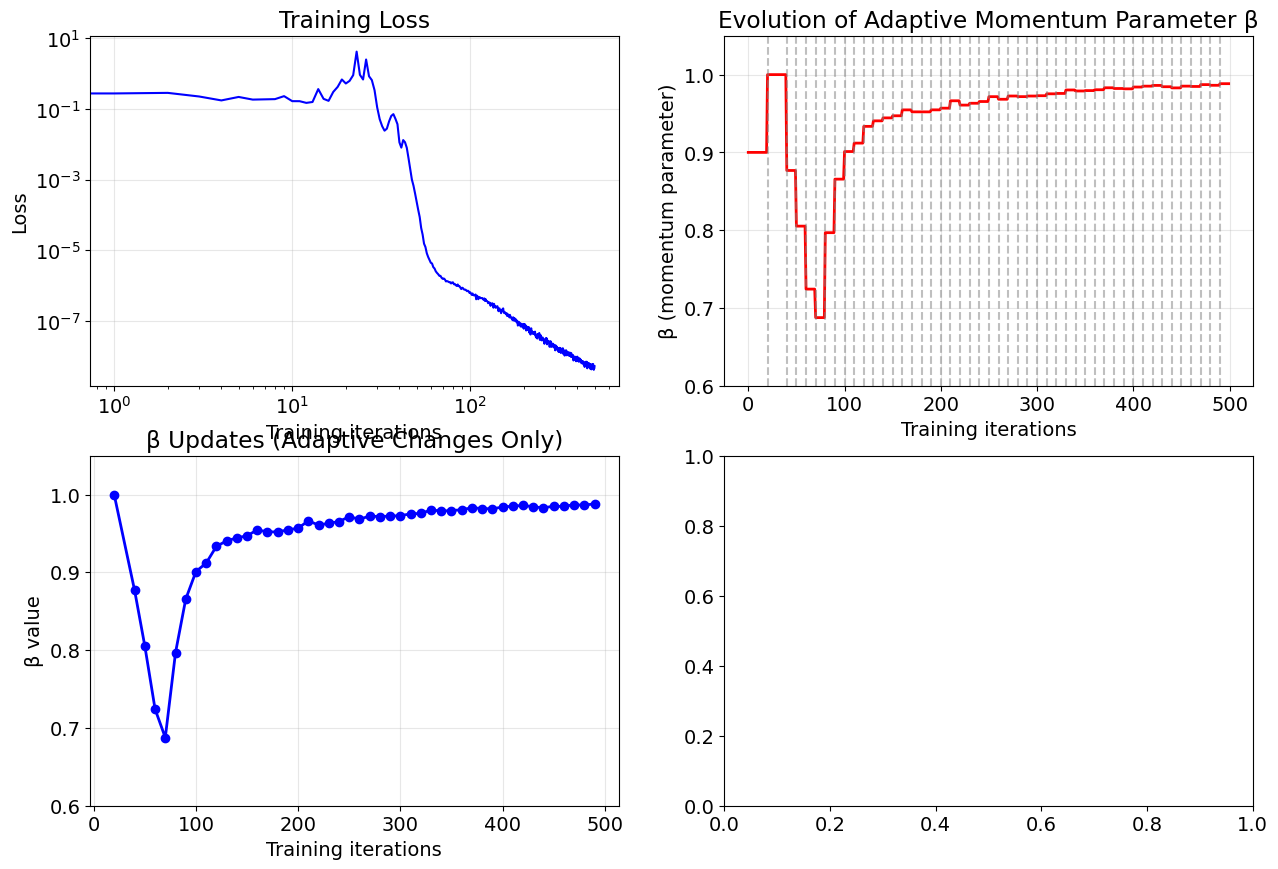

In [24]:
# Create the corrected visualization
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss over time
ax1.plot(loss_list, 'b-', linewidth=1.5)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Training iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

# Plot 2: β evolution over time
ax2.plot(beta_history, 'r-', linewidth=2)
ax2.set_xlabel('Training iterations')
ax2.set_ylabel('β (momentum parameter)')
ax2.set_title('Evolution of Adaptive Momentum Parameter β')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.6, 1.05])

# Highlight the update points
for update_iter in update_iterations:
    ax2.axvline(x=update_iter, color='gray', linestyle='--', alpha=0.5)

# Plot 3: β updates only (cleaner view)
beta_updates = [beta_history[i] for i in update_iterations]
ax3.plot(update_iterations, beta_updates, 'bo-', markersize=6, linewidth=2)
ax3.set_xlabel('Training iterations')
ax3.set_ylabel('β value')
ax3.set_title('β Updates (Adaptive Changes Only)')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0.6, 1.05])

# Plot 4: ρ evolution (momentum strength indicator)
ax4.plot(update_iterations, rho_history, 'go-', markersize=6, linewidth=2)
ax4.set_xlabel('Training iterations')
ax4.set_ylabel('ρ (momentum reduction factor)')
ax4.set_title('ρ Evolution (Higher ρ = Less Momentum)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## minSR (SPRING w/ beta = 0) VS SPRING (Adaptive Momentum)

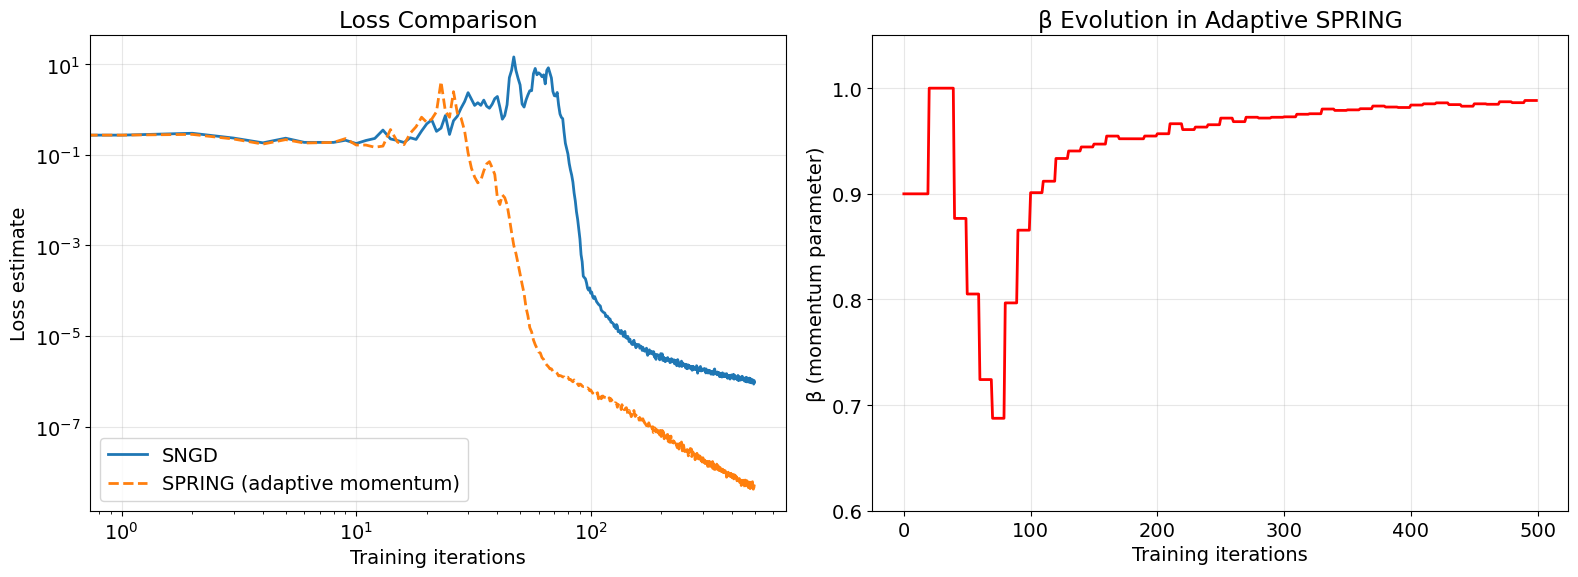

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Loss comparison
ax1.plot(loss_list_clean, label="SNGD", linewidth=2)
ax1.plot(loss_list_aa, label="SPRING (adaptive momentum)", linestyle="--", linewidth=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss estimate")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title("Loss Comparison")

# Right plot: Beta evolution
ax2.plot(beta_history, color='red', linewidth=2)
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("β (momentum parameter)")
ax2.set_title("β Evolution in Adaptive SPRING")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.6, 1.05])

plt.tight_layout()
plt.show()

## Comparing minSR and SPRING across eta values

In [181]:
eta_vals = [0.1, 0.3, 0.5, 0.7]
num_it = 1000
lamb = 1e-2
p = 10
batch_size = 500

minSR_losses = []
spring_adaptive_losses = []

for eta in eta_vals:
    print(f"minSR vs SPRING adaptive for eta = {eta}")
    
    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # minSR
    params_clean = params
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params_clean, rng, dummy_x, eta, beta=0, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params_clean, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params_clean, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    minSR_losses.append(loss_list_clean)

    # SPRING adaptive
    params_adaptive = params
    loss_list_adaptive = []
    opt_state_adaptive, opt_step_adaptive, rng_adaptive = get_spring_optimizer(params_adaptive, rng, dummy_x, eta, lamb, p)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng, key = jax.random.split(rng)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state_adaptive, rng, loss, _ = opt_step_adaptive(params, batch, targets, opt_state_adaptive, rng, i)
            
            current_beta = float(opt_state_adaptive.beta)
            loss_list_adaptive.append(loss)

            # Show β in progress bar
            if i >= 20 and i % 10 == 0:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
            else:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")


    spring_adaptive_losses.append(loss_list_adaptive)

minSR vs SPRING adaptive for eta = 0.1


Loss 1.689e-07, β: 0.991: 100%|████████████| 1000/1000 [00:22<00:00, 43.90its/s]


minSR vs SPRING adaptive for eta = 0.3


Loss 8.981e-08, β: 0.994: 100%|████████████| 1000/1000 [00:24<00:00, 40.57its/s]


minSR vs SPRING adaptive for eta = 0.5


Loss 5.546e-09, β: 0.993: 100%|████████████| 1000/1000 [00:26<00:00, 37.75its/s]


minSR vs SPRING adaptive for eta = 0.7


Loss 1.370e-07, β: 0.994: 100%|████████████| 1000/1000 [00:21<00:00, 47.21its/s]


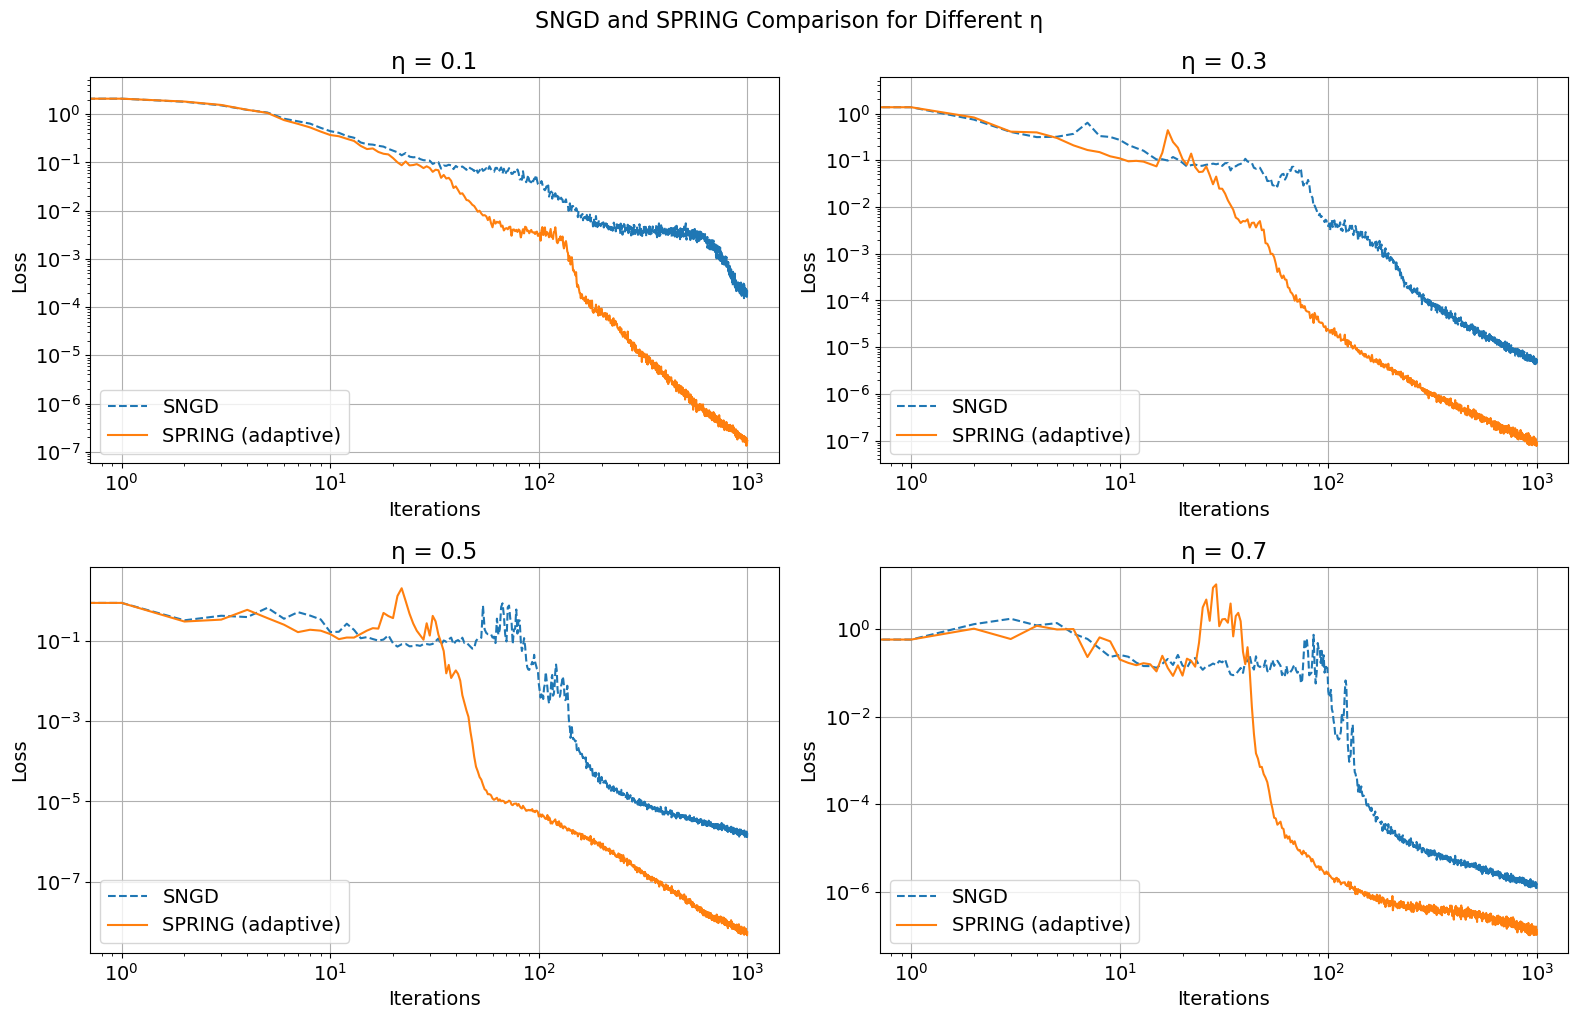

In [182]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(16, 10))

for idx, eta in enumerate(eta_vals):
    plt.subplot(2, 2, idx + 1)
    plt.plot(minSR_losses[idx], label="SNGD", linestyle="--")
    plt.plot(spring_adaptive_losses[idx], label="SPRING (adaptive)", color="tab:orange")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(f"η = {eta}")
    plt.legend(loc="lower left")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("SNGD and SPRING Comparison for Different η", y=1.02, fontsize=16)
# plt.savefig("spring_eta_comparison.pdf", bbox_inches="tight")
plt.show()

## Comparing best eta vs best eta

### Finding best eta for minSR

In [210]:
eta_vals = [0.5, 0.6, 0.7]
num_it = 1000
lamb = 1e-2
batch_size = 500

minSR_losses = []

for eta in eta_vals:
    print(f"minSR for eta value {eta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # minSR
    params_clean = params
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params_clean, rng, dummy_x, eta, beta=0, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params_clean, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params_clean, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    minSR_losses.append(loss_list_clean)


minSR for eta value 0.5


100%|██████████████████████████████████████| 1000/1000 [00:19<00:00, 51.32its/s]


minSR for eta value 0.6


100%|██████████████████████████████████████| 1000/1000 [00:19<00:00, 50.49its/s]


minSR for eta value 0.7


100%|██████████████████████████████████████| 1000/1000 [00:19<00:00, 50.98its/s]


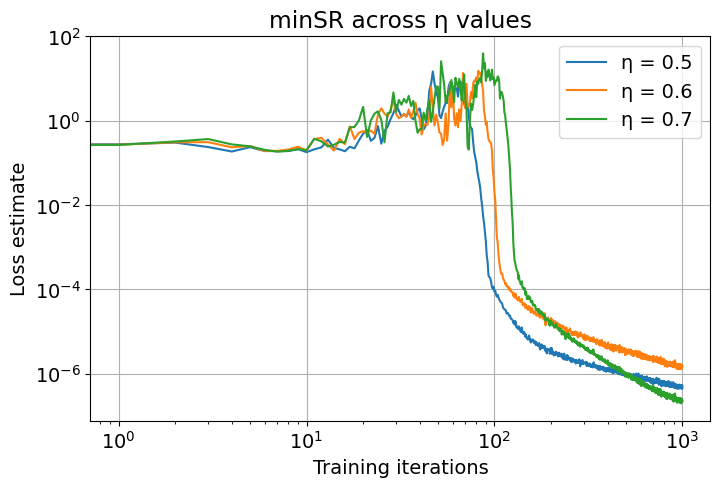

In [211]:
plt.figure(figsize=(8, 5))
for i, eta in enumerate(eta_vals):
    plt.plot(minSR_losses[i], label=f"η = {eta}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.title("minSR across η values")
plt.legend()
plt.grid(True)
# Optional: plt.savefig("minSR_eta_comparison.pdf", bbox_inches="tight")
plt.show()

### Finding best eta for SPRING

In [13]:
num_it = 1000
lamb = 1e-2
batch_size = 500
eta_vals = [0.1, 0.3, 0.5, 0.6, 0.7]
p = 10

spring_adaptive_losses = []

for eta in eta_vals:
    print(f"SPRING for eta value {eta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # SPRING adaptive
    params_adaptive = params
    loss_list_adaptive = []
    opt_state_adaptive, opt_step_adaptive, rng_adaptive = get_spring_optimizer(params_adaptive, rng, dummy_x, eta, lamb, p)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng, key = jax.random.split(rng)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state_adaptive, rng, loss, _ = opt_step_adaptive(params, batch, targets, opt_state_adaptive, rng, i)
            
            current_beta = float(opt_state_adaptive.beta)
            loss_list_adaptive.append(loss)

            # Show β in progress bar
            if i >= 20 and i % 10 == 0:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
            else:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")


    spring_adaptive_losses.append(loss_list_adaptive)


SPRING for eta value 0.1


Loss 1.339e-07, β: 0.993: 100%|████████████| 1000/1000 [00:22<00:00, 44.50its/s]


SPRING for eta value 0.3


Loss 2.125e-08, β: 0.994: 100%|████████████| 1000/1000 [00:23<00:00, 41.91its/s]


SPRING for eta value 0.5


Loss 1.275e-09, β: 0.995: 100%|████████████| 1000/1000 [00:22<00:00, 44.06its/s]


SPRING for eta value 0.6


Loss 2.430e-07, β: 0.993: 100%|████████████| 1000/1000 [00:22<00:00, 45.10its/s]


SPRING for eta value 0.7


Loss 2.038e-08, β: 0.994: 100%|████████████| 1000/1000 [00:22<00:00, 44.94its/s]


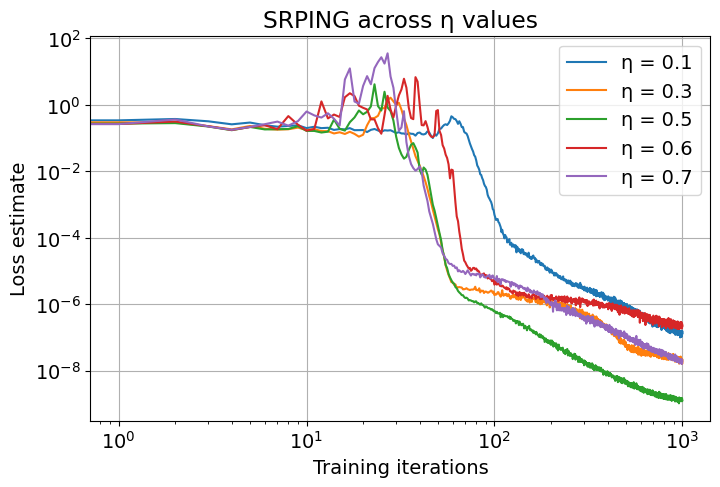

In [14]:
plt.figure(figsize=(8, 5))
for i, eta in enumerate(eta_vals):
    plt.plot(spring_adaptive_losses[i], label=f"η = {eta}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.title("SRPING across η values")
plt.legend()
plt.grid(True)
# Optional: plt.savefig("minSR_eta_comparison.pdf", bbox_inches="tight")
plt.show()

### best eta vs best eta

In [187]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
minSR_eta = 0.6 #learning rate 
beta = 0

num_it = 3000

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_spring_optimizer_clean(params, rng, dummy_x, minSR_eta, beta, lamb)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

loss_list_clean = loss_list

Loss 2.664e-07: 100%|██████████████████████| 3000/3000 [01:04<00:00, 46.83its/s]


In [188]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
spring_eta =  0.5 #learning rate 
p = 10

num_it = 3000

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_spring_optimizer(params, rng, dummy_x, spring_eta, lamb, p)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

loss_list_aa = loss_list

Loss 5.981e-10: 100%|██████████████████████| 3000/3000 [01:08<00:00, 43.59its/s]


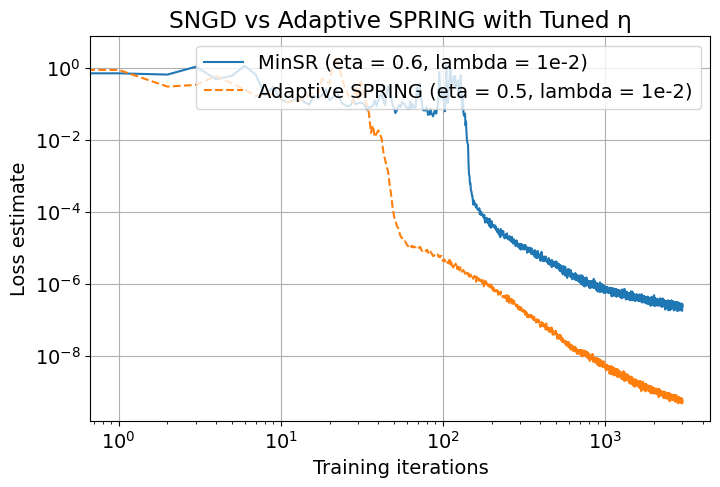

In [189]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.figure(figsize=(8, 5))
plt.plot(loss_list_clean, label=f"MinSR (eta = {minSR_eta}, lambda = 1e-2)")
plt.plot(loss_list_aa, label=f"Adaptive SPRING (eta = {spring_eta}, lambda = 1e-2)", linestyle="--")

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.legend()
plt.grid(True)
plt.title("SNGD vs Adaptive SPRING with Tuned η")

# Optional: save to file
# plt.savefig("SPRING_comparison.pdf", bbox_inches="tight")
plt.show()

## Testing whether adaptive beta is the best

In [24]:
#beta_vals = [0.86, 0.85, 0.84]
#beta_vals = [0.95, 0.9, 0.87, 0.85]
beta_vals = [0, 0.5, 0.7, 0.85, 0.9, 0.99]
#beta_vals = [0.855, 0.95]
num_it = 1000
lamb = 1e-2
batch_size = 500
eta = 0.5

spring_losses = []

for beta in beta_vals:
    print(f"SPRING for beta value {beta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # SPRING
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    spring_losses.append(loss_list_clean)


SPRING for beta value 0


100%|██████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.63its/s]


SPRING for beta value 0.5


100%|██████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.29its/s]


SPRING for beta value 0.7


100%|██████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.92its/s]


SPRING for beta value 0.85


100%|██████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.76its/s]


SPRING for beta value 0.9


100%|██████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.83its/s]


SPRING for beta value 0.99


100%|██████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.78its/s]


In [25]:
rng = jax.random.PRNGKey(seed)
lamb = 1e-2
eta = 0.5
p = 10
num_it = 1000  # Full run

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
loss_list = []
beta_history = []
rho_history = []
update_iterations = []

opt_state, opt_step, rng = get_spring_optimizer(params, rng, dummy_x, eta, lamb, p)
batch_size = 500

print("Running full training with β tracking...")

with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]
        params, opt_state, rng, loss, _ = opt_step(params, batch, targets, opt_state, rng, i)
        
        current_beta = float(opt_state.beta)
        beta_history.append(current_beta)
        loss_list.append(loss)
        
        # Track when β actually changes
        if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
            update_iterations.append(i)
        
        # Show β in progress bar
        if i >= 20 and i % 10 == 0:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
        else:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
loss_list_aa = loss_list

Running full training with β tracking...


Loss 1.275e-09, β: 0.995: 100%|████████████████| 1000/1000 [00:18<00:00, 52.97its/s]


In [195]:
spring_losses.pop(-1)

[Array(2.5070095, dtype=float32),
 Array(0.8670309, dtype=float32),
 Array(0.2984622, dtype=float32),
 Array(0.3329434, dtype=float32),
 Array(0.5833471, dtype=float32),
 Array(0.36305112, dtype=float32),
 Array(0.24891886, dtype=float32),
 Array(0.16255222, dtype=float32),
 Array(0.18643472, dtype=float32),
 Array(0.17683047, dtype=float32),
 Array(0.1455377, dtype=float32),
 Array(0.10897801, dtype=float32),
 Array(0.11935491, dtype=float32),
 Array(0.11898463, dtype=float32),
 Array(0.14656278, dtype=float32),
 Array(0.17756742, dtype=float32),
 Array(0.20404594, dtype=float32),
 Array(0.19880931, dtype=float32),
 Array(0.48890415, dtype=float32),
 Array(0.40831488, dtype=float32),
 Array(0.36310318, dtype=float32),
 Array(1.2878478, dtype=float32),
 Array(2.008016, dtype=float32),
 Array(0.9620684, dtype=float32),
 Array(0.46530682, dtype=float32),
 Array(0.2656294, dtype=float32),
 Array(0.17605579, dtype=float32),
 Array(0.13493627, dtype=float32),
 Array(0.10537837, dtype=float3

In [26]:
spring_losses.append(loss_list_aa)

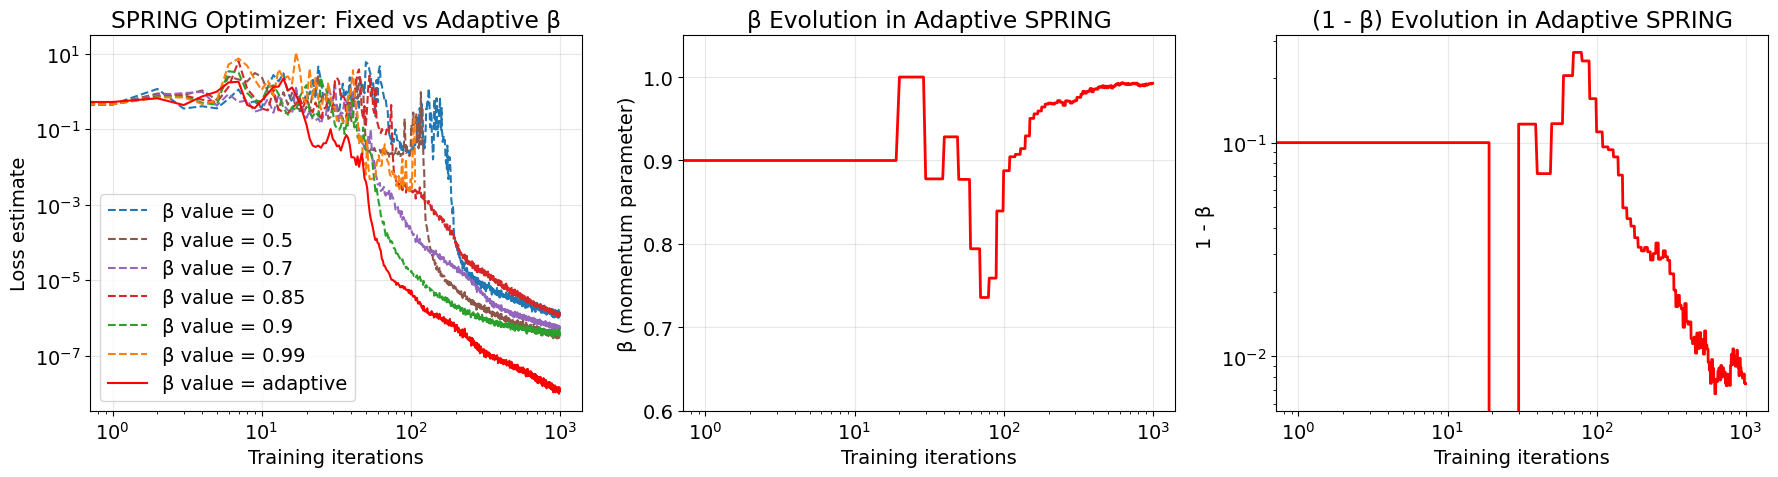

In [137]:
#spring_losses.pop(-1)
#colors = ['#084594', '#dae7f7', '#bcd9ec', '#9ecae1', '#6baed6', '#4292c6']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Left plot: Loss comparison
for i, beta in enumerate(beta_vals):
    ax1.plot(spring_losses[i], label=f"β value = {beta}", color=colors[-i], linestyle="--")
ax1.plot(spring_losses[-1], label=f"β value = adaptive", color='#FF0000')
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss estimate")
ax1.set_title("SPRING Optimizer: Fixed vs Adaptive β")
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

# Right plot: Beta evolution
ax2.plot(beta_history, color='red', linewidth=2)
ax2.set_xscale("log")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("β (momentum parameter)")
ax2.set_title("β Evolution in Adaptive SPRING")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.6, 1.05])

l = 1-jnp.array(beta_history)
ax3.plot(l, color='red', linewidth=2)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Training iterations")
ax3.set_ylabel("1 - β ")
ax3.set_title("(1 - β) Evolution in Adaptive SPRING")
ax3.grid(True, alpha=0.3)


plt.tight_layout()
plt.grid(True)
# Optional: plt.savefig("spring_beta_comparison.pdf", bbox_inches="tight")
plt.show()

(0.6, 1.05)

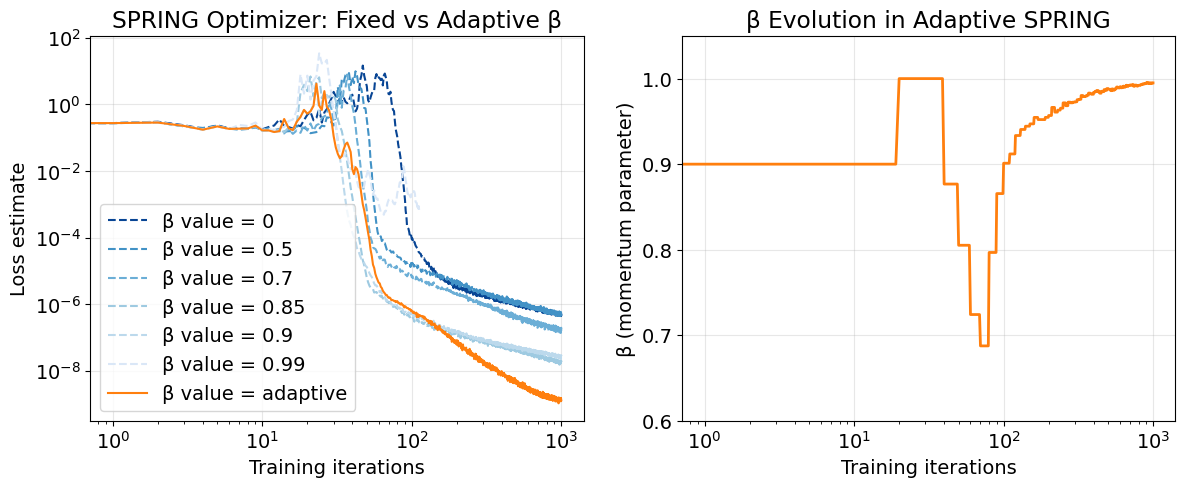

In [28]:
#spring_losses.pop(-1)
colors = ['#084594', '#dae7f7', '#bcd9ec', '#9ecae1', '#6baed6', '#4292c6']
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Loss comparison
for i, beta in enumerate(beta_vals):
    ax1.plot(spring_losses[i], label=f"β value = {beta}", color=colors[-i], linestyle="--")
ax1.plot(spring_losses[-1], label=f"β value = adaptive", color='tab:orange')
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss estimate")
ax1.set_title("SPRING Optimizer: Fixed vs Adaptive β")
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

# Right plot: Beta evolution
ax2.plot(beta_history, color='tab:orange', linewidth=2)
#ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("β (momentum parameter)")
ax2.set_title("β Evolution in Adaptive SPRING")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.6, 1.05])

## Testing lookback window (p)

In [16]:
rng = jax.random.PRNGKey(seed)
beta_vals = [0, 0.5, 0.7, 0.85, 0.9, 0.99]
p_vals = [5, 10, 15, 20, 30]
num_it = 1000
lamb = 1e-2
batch_size = 500
eta = 0.5

beta_losses = []

for beta in beta_vals:
    print(f"Non-adaptive SPRING for beta value {beta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # SPRING
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    beta_losses.append(loss_list_clean)

Non-adaptive SPRING for beta value 0


100%|██████████████████████████████████████| 1000/1000 [00:19<00:00, 50.02its/s]


Non-adaptive SPRING for beta value 0.5


100%|██████████████████████████████████████| 1000/1000 [00:19<00:00, 50.81its/s]


Non-adaptive SPRING for beta value 0.7


100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 54.57its/s]


Non-adaptive SPRING for beta value 0.85


100%|██████████████████████████████████████| 1000/1000 [00:19<00:00, 51.95its/s]


Non-adaptive SPRING for beta value 0.9


100%|██████████████████████████████████████| 1000/1000 [00:20<00:00, 49.89its/s]


Non-adaptive SPRING for beta value 0.99


100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 54.95its/s]


In [21]:
rng = jax.random.PRNGKey(seed)
beta_vals = [0, 0.5, 0.7, 0.85, 0.9, 0.99]
p_vals = [5, 10, 15, 20, 30]
num_it = 1000
lamb = 1e-2
batch_size = 500
eta = 0.5

p_losses = []
beta_histories = []

for p in p_vals:
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)
    
    loss_list = []
    beta_history = []
    rho_history = []
    update_iterations = []

    opt_state, opt_step, rng = get_spring_optimizer(params, rng, dummy_x, eta, lamb, p)

    print(f"p value = {p}")

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng, key = jax.random.split(rng)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state, rng, loss, _ = opt_step(params, batch, targets, opt_state, rng, i)

            current_beta = float(opt_state.beta)
            beta_history.append(current_beta)
            loss_list.append(loss)

            # Track when β actually changes
            if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
                update_iterations.append(i)

            # Show β in progress bar
            if i >= 20 and i % 10 == 0:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
            else:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
    p_losses.append(loss_list)
    beta_histories.append(beta_history)

p value = 5


Loss 7.289e-08, β: 0.985: 100%|████████████| 1000/1000 [00:24<00:00, 40.14its/s]


p value = 10


Loss 1.275e-09, β: 0.995: 100%|████████████| 1000/1000 [00:22<00:00, 45.32its/s]


p value = 15


Loss 4.909e-09, β: 0.995: 100%|████████████| 1000/1000 [00:27<00:00, 36.97its/s]


p value = 20


Loss 2.165e-09, β: 0.996: 100%|████████████| 1000/1000 [00:22<00:00, 43.52its/s]


p value = 30


Loss 1.795e-09, β: 0.995: 100%|████████████| 1000/1000 [00:27<00:00, 36.35its/s]


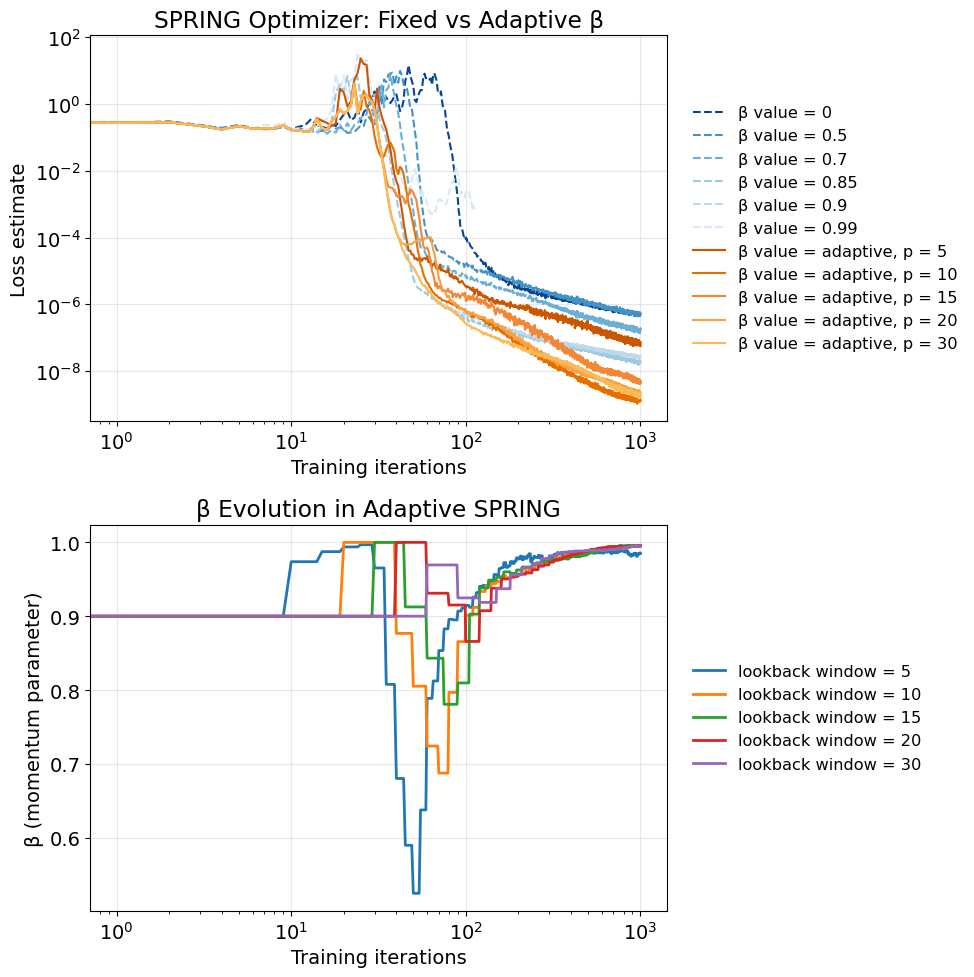

In [43]:
blue_colors = ['#084594', '#dae7f7', '#bcd9ec', '#9ecae1', '#6baed6', '#4292c6']
orange_colors = ["#cc5500", "#e76f00", "#f58634", "#f9a03f", "#fcba57"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Left plot: Loss comparison
for i, beta in enumerate(beta_vals):
    ax1.plot(beta_losses[i], label=f"β value = {beta}", color=blue_colors[-i], linestyle="--")
for j, p in enumerate(p_vals):
    ax1.plot(p_losses[j], label=f"β value = adaptive, p = {p}", color=orange_colors[j])
    
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss estimate")
ax1.set_title("SPRING Optimizer: Fixed vs Adaptive β")
ax1.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', frameon=False)
ax1.grid(True, alpha=0.3)

# Right plot: Beta evolution
for k, p in enumerate(p_vals):
    ax2.plot(beta_histories[k], label=f"lookback window = {p}", linewidth=2)
#ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("β (momentum parameter)")
ax2.set_title("β Evolution in Adaptive SPRING")
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', frameon=False)
ax2.grid(True, alpha=0.3)
plt.tight_layout()

## Testing batch sizes

In [18]:
eta_vals = [0.1, 0.3, 0.5, 0.7]
num_it = 3000
lamb = 1e-2
p = 10
batch_vals = [50, 100, 500]

minSR_losses = []
spring_adaptive_losses = []

for batch_size in batch_vals:
    for eta in eta_vals:
        print(f"SNGD vs SPRING adaptive for batch = {batch_size}, eta = {eta}")

        # Re-initialize parameters for a fair comparison
        rng = jax.random.PRNGKey(seed)
        rng, key = jax.random.split(rng)
        params = model_fn.init(key, dummy_x)

        # minSR
        params_clean = params
        loss_list_clean = []
        opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params_clean, rng, dummy_x, eta, beta=0, lamb=lamb)

        with trange(num_it, unit="its", position=0, leave=True) as pbar:
            for i in pbar:
                rng_clean, key = jax.random.split(rng_clean)
                batch = jax.random.uniform(key, shape=(batch_size, 1))
                targets = target_fn(batch)[:, 0]
                params_clean, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params_clean, batch, targets, opt_state_clean, rng_clean)
                loss_list_clean.append(loss)

        minSR_losses.append(loss_list_clean)

        # SPRING adaptive
        params_adaptive = params
        loss_list_adaptive = []
        opt_state_adaptive, opt_step_adaptive, rng_adaptive = get_spring_optimizer(params_adaptive, rng, dummy_x, eta, lamb, p)

        with trange(num_it, unit="its", position=0, leave=True) as pbar:
            for i in pbar:
                rng, key = jax.random.split(rng)
                batch = jax.random.uniform(key, shape=(batch_size, 1))
                targets = target_fn(batch)[:, 0]
                params, opt_state_adaptive, rng, loss, _ = opt_step_adaptive(params, batch, targets, opt_state_adaptive, rng, i)

                current_beta = float(opt_state_adaptive.beta)
                loss_list_adaptive.append(loss)

                # Show β in progress bar
                if i >= 20 and i % 10 == 0:
                    pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
                else:
                    pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")


        spring_adaptive_losses.append(loss_list_adaptive)

SNGD vs SPRING adaptive for batch = 50, eta = 0.1


Loss 1.276e-08, β: 0.981: 100%|███████████████| 3000/3000 [00:09<00:00, 320.99its/s]


SNGD vs SPRING adaptive for batch = 50, eta = 0.3


Loss 4.025e-08, β: 0.981: 100%|███████████████| 3000/3000 [00:09<00:00, 318.53its/s]


SNGD vs SPRING adaptive for batch = 50, eta = 0.5


Loss 4.741e-08, β: 0.974: 100%|███████████████| 3000/3000 [00:08<00:00, 342.88its/s]


SNGD vs SPRING adaptive for batch = 50, eta = 0.7


Loss 1.151e-06, β: 0.966: 100%|███████████████| 3000/3000 [00:08<00:00, 354.55its/s]


SNGD vs SPRING adaptive for batch = 100, eta = 0.1


Loss 9.009e-09, β: 0.990: 100%|███████████████| 3000/3000 [00:09<00:00, 303.76its/s]


SNGD vs SPRING adaptive for batch = 100, eta = 0.3


Loss 3.407e-09, β: 0.991: 100%|███████████████| 3000/3000 [00:09<00:00, 304.37its/s]


SNGD vs SPRING adaptive for batch = 100, eta = 0.5


Loss 5.512e-07, β: 0.964: 100%|███████████████| 3000/3000 [00:10<00:00, 273.86its/s]


SNGD vs SPRING adaptive for batch = 100, eta = 0.7


Loss 1.516e-08, β: 0.987: 100%|███████████████| 3000/3000 [00:09<00:00, 300.72its/s]


SNGD vs SPRING adaptive for batch = 500, eta = 0.1


Loss 1.465e-08, β: 0.995: 100%|████████████████| 3000/3000 [00:54<00:00, 54.67its/s]


SNGD vs SPRING adaptive for batch = 500, eta = 0.3


Loss 3.931e-09, β: 0.996: 100%|████████████████| 3000/3000 [00:54<00:00, 54.94its/s]


SNGD vs SPRING adaptive for batch = 500, eta = 0.5


Loss 4.758e-10, β: 0.997: 100%|████████████████| 3000/3000 [00:54<00:00, 54.99its/s]


SNGD vs SPRING adaptive for batch = 500, eta = 0.7


Loss 3.038e-09, β: 0.997: 100%|████████████████| 3000/3000 [00:55<00:00, 54.43its/s]


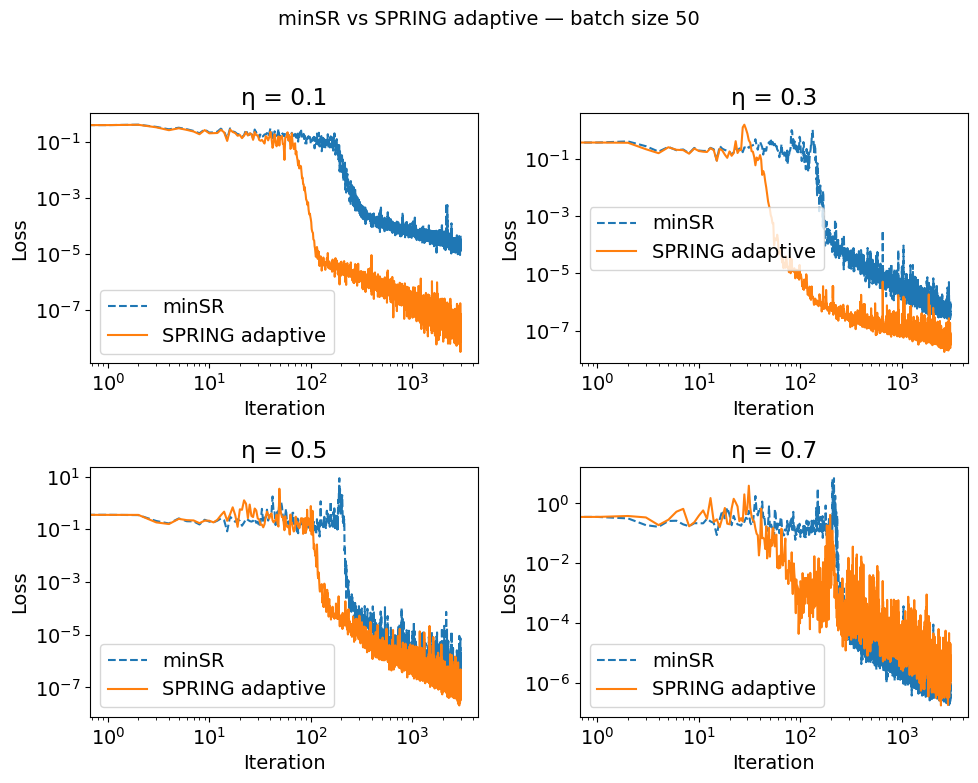

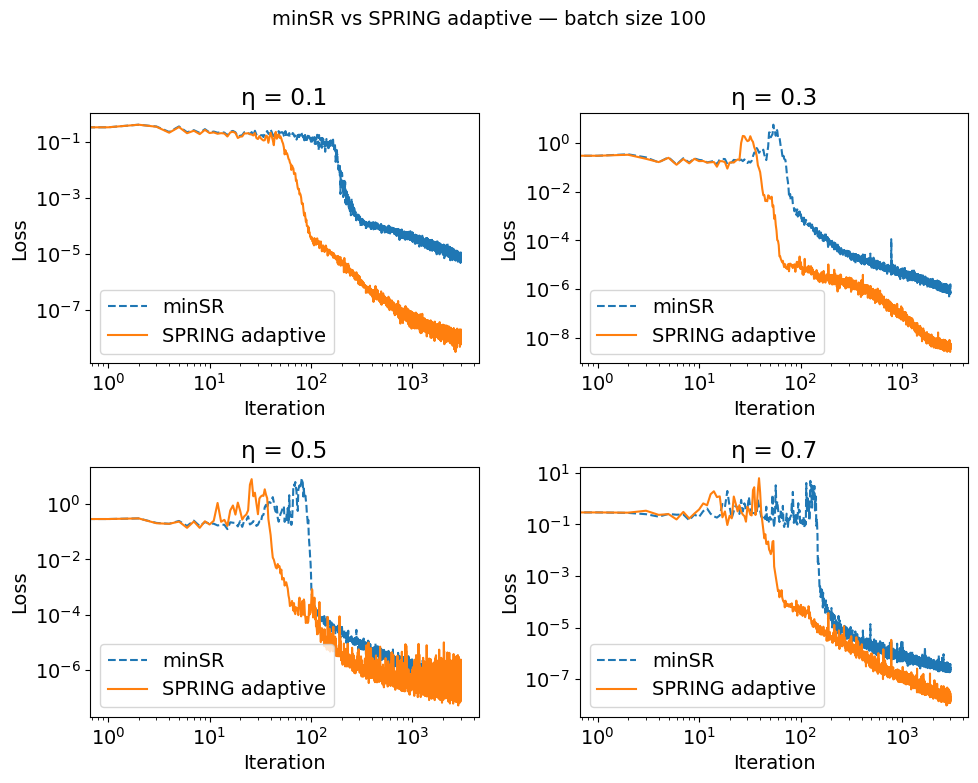

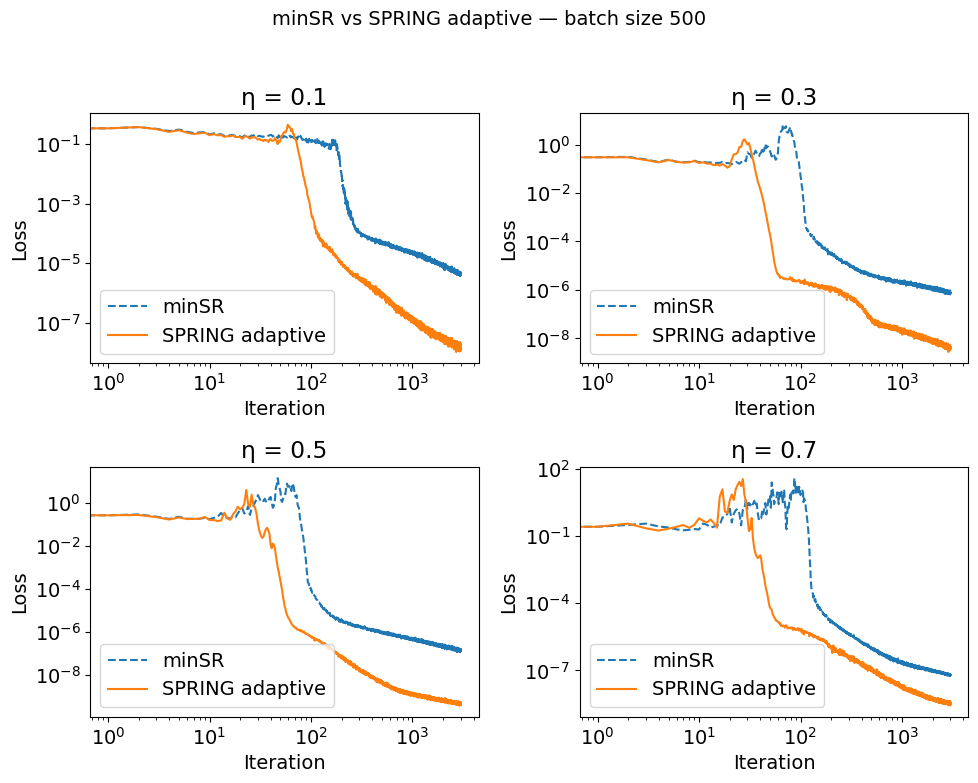

In [21]:
def idx(batch_idx, eta_idx):
    return batch_idx * len(eta_vals) + eta_idx

for b_idx, batch_size in enumerate(batch_vals):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for e_idx, eta in enumerate(eta_vals):
        i = idx(b_idx, e_idx)
        ax = axes[e_idx]
        ax.plot(minSR_losses[i], '--', label="minSR")
        ax.plot(spring_adaptive_losses[i], '-', label="SPRING adaptive")
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_title(f"η = {eta}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.legend()

    fig.suptitle(f"minSR vs SPRING adaptive — batch size {batch_size}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [39]:
# config
beta_vals  = [0, 0.5, 0.7, 0.85, 0.9, 0.99]
batch_vals = [50, 100, 500]
num_it = 1000
lamb   = 1e-2
eta    = 0.3

spring_losses = {bs: [] for bs in batch_vals}  # bs -> list of loss curves in beta_vals order

for b_idx, batch_size in enumerate(batch_vals):
    print(f"\nRunning fixed-β SPRING for batch_size={batch_size}")

    # SAME init for all β at this batch size
    rng0 = jax.random.PRNGKey(seed + 1000*b_idx)
    _, key_params = jax.random.split(rng0)
    params0 = model_fn.init(key_params, dummy_x)

    # SAME minibatch stream for all β at this batch size
    rng_batches = jax.random.PRNGKey(seed + 2000*b_idx)
    batch_keys  = jax.random.split(rng_batches, num_it)
    batches     = [jax.random.uniform(k, shape=(batch_size, 1)) for k in batch_keys]
    targets_lst = [target_fn(x)[:, 0] for x in batches]

    # run each β from identical params0 and batches
    for j, beta in enumerate(beta_vals):
        print(f"  β = {beta}")
        # separate RNG for optimizer’s internal randomness
        rng_run = jax.random.PRNGKey(seed + 3000*b_idx + j)
        rng_run, key_opt = jax.random.split(rng_run)

        params_clean = params0
        opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(
            params_clean, key_opt, dummy_x, eta, beta, lamb=lamb
        )

        loss_list_clean = []
        for i in trange(num_it, unit="its", position=0, leave=False):
            params_clean, opt_state_clean, rng_clean, loss, _ = opt_step_clean(
                params_clean, batches[i], targets_lst[i], opt_state_clean, rng_clean
            )
            loss_list_clean.append(loss)

        spring_losses[batch_size].append(loss_list_clean)



Running fixed-β SPRING for batch_size=50
  β = 0


  β = 0.5


  β = 0.7


  β = 0.85


  β = 0.9


  β = 0.99



Running fixed-β SPRING for batch_size=100
  β = 0


  β = 0.5


  β = 0.7


  β = 0.85


  β = 0.9


  β = 0.99



Running fixed-β SPRING for batch_size=500
  β = 0


  β = 0.5


  β = 0.7


  β = 0.85


  β = 0.9


  β = 0.99


In [40]:
# --- config ---
batch_vals = [50, 100, 500]
num_it = 1000
lamb = 1e-2
eta = 0.3
p = 10

# --- run adaptive SPRING for each batch size ---
rng = jax.random.PRNGKey(seed)

adaptive_losses   = {}  # batch_size -> [loss_t]
beta_histories    = {}  # batch_size -> [beta_t]
update_iters_dict = {}  # batch_size -> [t where beta changed]

print("Running adaptive SPRING across batch sizes...")
for b_idx, batch_size in enumerate(batch_vals):
    # fresh init per batch size (keeps runs independent)
    rng, key_params = jax.random.split(rng)
    params = model_fn.init(key_params, dummy_x)

    # fresh optimizer state and its own rng stream
    rng, key_opt = jax.random.split(rng)
    opt_state, opt_step, opt_rng = get_spring_optimizer(params, key_opt, dummy_x, eta, lamb, p)

    # per-batch histories
    loss_list = []
    beta_history = []
    update_iterations = []

    with trange(num_it, unit="its", position=0, leave=True, desc=f"batch={batch_size}") as pbar:
        for i in pbar:
            # use a dedicated rng stream for minibatches (separate from opt_rng)
            rng, key_batch = jax.random.split(rng)
            batch = jax.random.uniform(key_batch, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]

            params, opt_state, opt_rng, loss, _ = opt_step(params, batch, targets, opt_state, opt_rng, i)
            loss_list.append(loss)

            current_beta = float(opt_state.beta)
            beta_history.append(current_beta)

            if i > 0 and abs(beta_history[-1] - beta_history[-2]) > 1e-6:
                update_iterations.append(i)

            pbar.set_description(f"batch={batch_size} | Loss {loss:.3e}, β {current_beta:.3f}")

    adaptive_losses[batch_size]   = loss_list
    beta_histories[batch_size]    = beta_history
    update_iters_dict[batch_size] = update_iterations

Running adaptive SPRING across batch sizes...


batch=50 | Loss 2.222e-07, β 0.970: 100%|█████| 1000/1000 [00:02<00:00, 365.69its/s]
batch=100 | Loss 1.624e-08, β 0.983: 100%|████| 1000/1000 [00:03<00:00, 297.33its/s]
batch=500 | Loss 4.040e-09, β 0.994: 100%|█████| 1000/1000 [00:18<00:00, 55.26its/s]


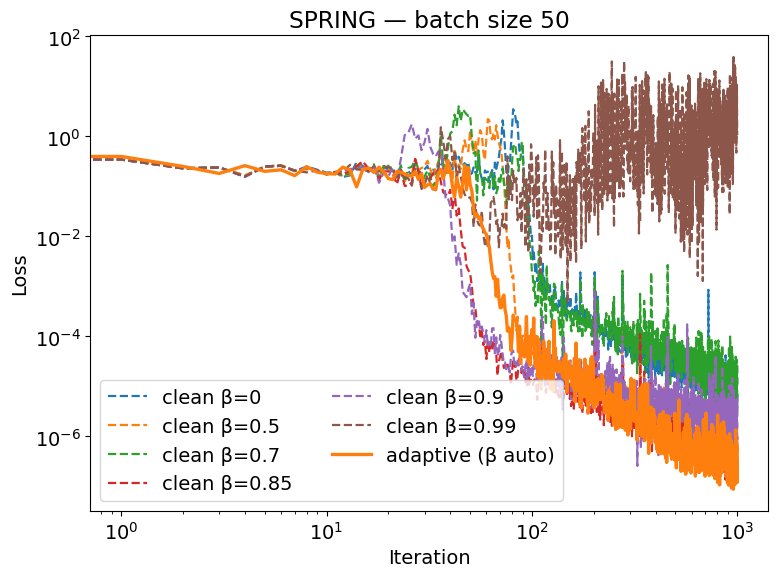

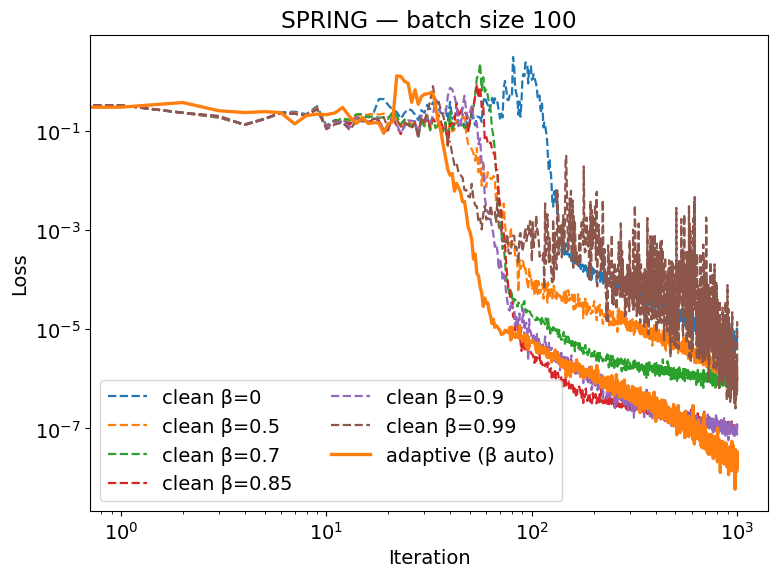

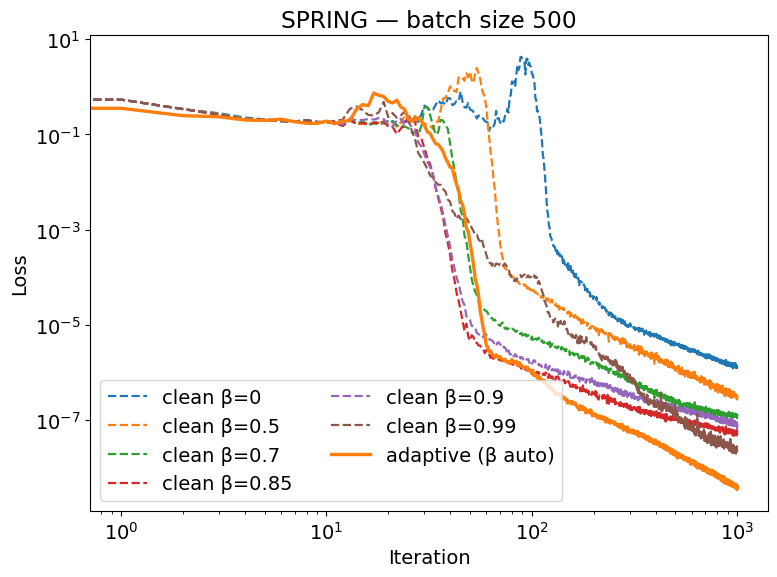

In [41]:
for batch_size in batch_vals:
    plt.figure(figsize=(8, 6))
    
    # fixed-β (clean) curves
    for j, beta in enumerate(beta_vals):
        losses = spring_losses[batch_size][j]
        plt.plot(losses, '--', linewidth=1.6, label=f'clean β={beta}')
    
    # adaptive curve
    plt.plot(adaptive_losses[batch_size], '-', linewidth=2.4, color='tab:orange', label='adaptive (β auto)')

    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Iteration'); plt.ylabel('Loss')
    plt.title(f'SPRING — batch size {batch_size}')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

### testing for batch = 100

In [48]:
#beta_vals = [0.86, 0.85, 0.84]
#beta_vals = [0.95, 0.9, 0.87, 0.85]
beta_vals = [0, 0.5, 0.7, 0.85, 0.9]
#beta_vals = [0.855, 0.95]
num_it = 1000
lamb = 1e-2
batch_size = 100
eta = 0.3

spring_losses = []

for beta in beta_vals:
    print(f"SPRING for beta value {beta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # SPRING
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    spring_losses.append(loss_list_clean)


SPRING for beta value 0


100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.47its/s]


SPRING for beta value 0.5


100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 468.83its/s]


SPRING for beta value 0.7


100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.20its/s]


SPRING for beta value 0.85


100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 470.81its/s]


SPRING for beta value 0.9


100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 469.27its/s]


In [49]:
rng = jax.random.PRNGKey(seed)
lamb = 1e-2
eta = 0.3
p = 10
num_it = 1000  # Full run

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
loss_list = []
beta_history = []
rho_history = []
update_iterations = []

opt_state, opt_step, rng = get_spring_optimizer(params, rng, dummy_x, eta, lamb, p)
batch_size = 100

print("Running full training with β tracking...")

with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]
        params, opt_state, rng, loss, _ = opt_step(params, batch, targets, opt_state, rng, i)
        
        current_beta = float(opt_state.beta)
        beta_history.append(current_beta)
        loss_list.append(loss)
        
        # Track when β actually changes
        if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
            update_iterations.append(i)
        
        # Show β in progress bar
        if i >= 20 and i % 10 == 0:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
        else:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
loss_list_aa = loss_list

Running full training with β tracking...


Loss 9.161e-08, β: 0.989: 100%|███████████████| 1000/1000 [00:03<00:00, 275.89its/s]


In [50]:
spring_losses.append(loss_list_aa)

(0.6, 1.05)

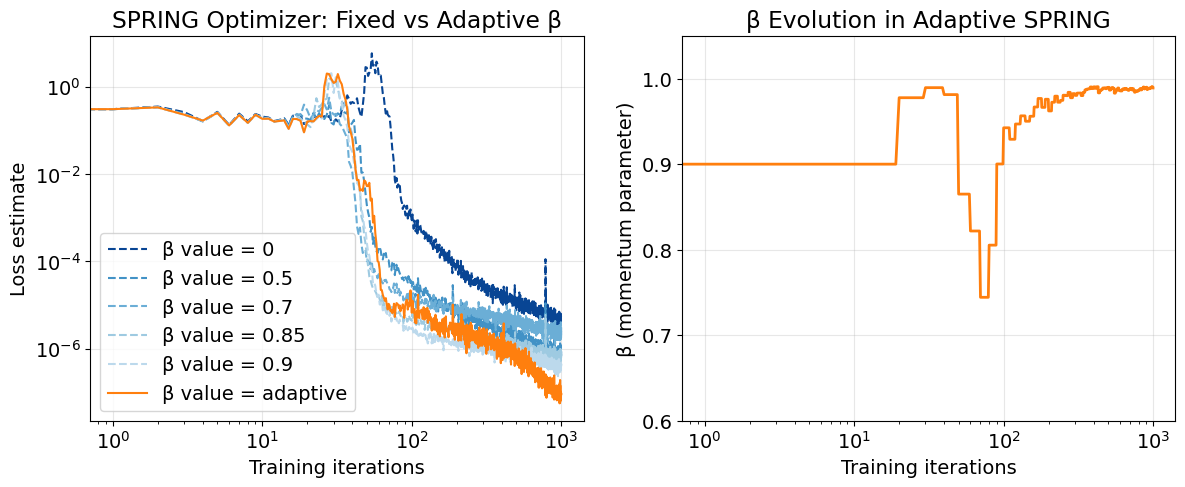

In [51]:
#spring_losses.pop(-1)
colors = ['#084594', '#dae7f7', '#bcd9ec', '#9ecae1', '#6baed6', '#4292c6']
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Loss comparison
for i, beta in enumerate(beta_vals):
    ax1.plot(spring_losses[i], label=f"β value = {beta}", color=colors[-i], linestyle="--")
ax1.plot(spring_losses[-1], label=f"β value = adaptive", color='tab:orange')
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss estimate")
ax1.set_title("SPRING Optimizer: Fixed vs Adaptive β")
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

# Right plot: Beta evolution
ax2.plot(beta_history, color='tab:orange', linewidth=2)
#ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("β (momentum parameter)")
ax2.set_title("β Evolution in Adaptive SPRING")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.6, 1.05])

### testing for batch = 100

In [57]:
#beta_vals = [0.86, 0.85, 0.84]
#beta_vals = [0.95, 0.9, 0.87, 0.85]
beta_vals = [0, 0.5, 0.7, 0.85, 0.9, 0.99]
#beta_vals = [0.855, 0.95]
num_it = 1000
lamb = 1e-2
batch_size = 50
eta = 0.3

spring_losses = []

for beta in beta_vals:
    print(f"SPRING for beta value {beta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # SPRING
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    spring_losses.append(loss_list_clean)


SPRING for beta value 0


100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 619.86its/s]


SPRING for beta value 0.5


100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 625.81its/s]


SPRING for beta value 0.7


100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 637.71its/s]


SPRING for beta value 0.85


100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 631.29its/s]


SPRING for beta value 0.9


100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 628.80its/s]


SPRING for beta value 0.99


100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 636.45its/s]


In [58]:
rng = jax.random.PRNGKey(seed)
lamb = 1e-2
eta = 0.3
p = 10
num_it = 1000  # Full run

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
loss_list = []
beta_history = []
rho_history = []
update_iterations = []

opt_state, opt_step, rng = get_spring_optimizer(params, rng, dummy_x, eta, lamb, p)
batch_size = 50

print("Running full training with β tracking...")

with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]
        params, opt_state, rng, loss, _ = opt_step(params, batch, targets, opt_state, rng, i)
        
        current_beta = float(opt_state.beta)
        beta_history.append(current_beta)
        loss_list.append(loss)
        
        # Track when β actually changes
        if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
            update_iterations.append(i)
        
        # Show β in progress bar
        if i >= 20 and i % 10 == 0:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
        else:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
loss_list_aa = loss_list

Running full training with β tracking...


Loss 7.429e-08, β: 0.972: 100%|███████████████| 1000/1000 [00:03<00:00, 332.28its/s]


In [59]:
spring_losses.append(loss_list_aa)

(0.6, 1.05)

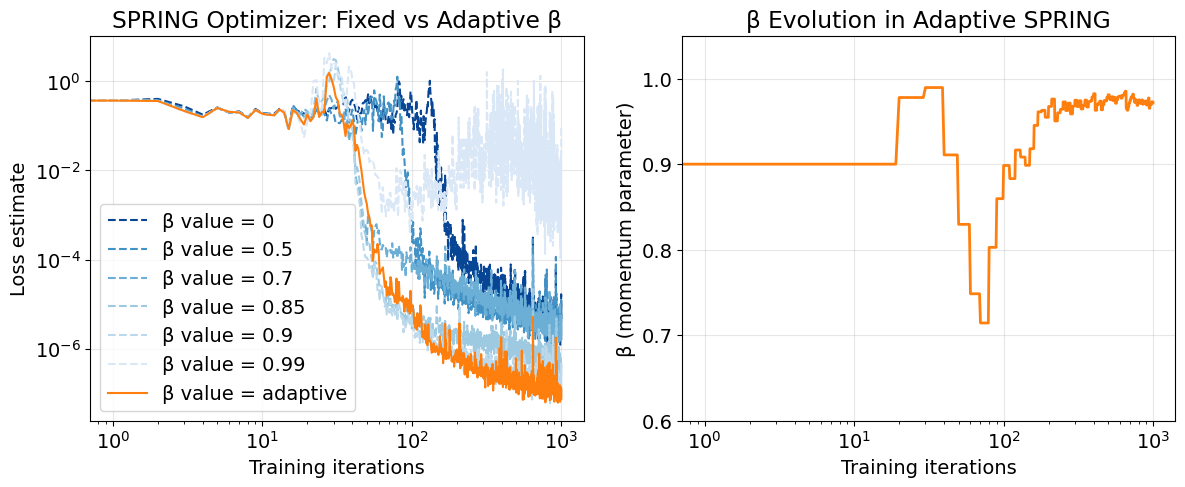

In [60]:
#spring_losses.pop(-1)
colors = ['#084594', '#dae7f7', '#bcd9ec', '#9ecae1', '#6baed6', '#4292c6']
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Loss comparison
for i, beta in enumerate(beta_vals):
    ax1.plot(spring_losses[i], label=f"β value = {beta}", color=colors[-i], linestyle="--")
ax1.plot(spring_losses[-1], label=f"β value = adaptive", color='tab:orange')
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss estimate")
ax1.set_title("SPRING Optimizer: Fixed vs Adaptive β")
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

# Right plot: Beta evolution
ax2.plot(beta_history, color='tab:orange', linewidth=2)
#ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("β (momentum parameter)")
ax2.set_title("β Evolution in Adaptive SPRING")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.6, 1.05])